## 1️⃣ Setup & Installation

First, we'll install all required dependencies. This cell checks if we're running in Google Colab and installs packages accordingly.

In [1]:
import sys
import os
from pathlib import Path

# Check if running in Google Colab
IN_COLAB = 'google.colab' in sys.modules

print(f"🔍 Environment: {'Google Colab' if IN_COLAB else 'Local Jupyter'}")
print(f"🐍 Python Version: {sys.version.split()[0]}")

if IN_COLAB:
    print("\n📦 Installing dependencies for Google Colab...")
    
    # Install required packages
    !pip install -q spacy transformers torch pandas numpy matplotlib seaborn plotly tqdm requests beautifulsoup4 sqlalchemy python-dotenv pyyaml
    
    # Download spaCy model
    !python -m spacy download en_core_web_sm
    
    # Clone repository (if needed)
    if not Path('/content/NLP-project').exists():
        print("\n📥 Cloning repository...")
        !git clone https://github.com/mohit07raghav19/NLP-Project.git /content/NLP-project
        os.chdir('/content/NLP-project')
    else:
        os.chdir('/content/NLP-project')
else:
    print("\n✅ Running locally - assuming dependencies are already installed")
    print("   If not, run: pip install -r requirements.txt")
    
    # Navigate to project root
    project_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
    os.chdir(project_root)
    print(f"📂 Working directory: {os.getcwd()}")

print("\n✅ Setup complete!")

🔍 Environment: Local Jupyter
🐍 Python Version: 3.10.0

✅ Running locally - assuming dependencies are already installed
   If not, run: pip install -r requirements.txt
📂 Working directory: E:\Learn\SEM-7\NLP\NLP-Project

✅ Setup complete!


### Import Required Libraries

Now let's import all the libraries we'll be using throughout this notebook.

In [2]:
# Standard library imports
import json
import pickle
import warnings
from datetime import datetime, timedelta
from collections import Counter, defaultdict
from typing import List, Dict, Any, Optional

# Data processing
import pandas as pd
import numpy as np

# NLP libraries
import spacy
from transformers import pipeline

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Database
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker

# HTTP requests
import requests
from tqdm.notebook import tqdm

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Configure pandas display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

print("✅ All libraries imported successfully!")
print(f"📊 Pandas version: {pd.__version__}")
print(f"🤖 spaCy available: {spacy.__version__}")

✅ All libraries imported successfully!
📊 Pandas version: 1.5.3
🤖 spaCy available: 3.8.3


### Configuration

Set up project configuration and API credentials.

In [3]:
# Configuration
CONFIG = {
    'nvd_api_key': None,  # Set this to your NVD API key or leave None
    'cache_enabled': True,
    'rate_limit_delay': 0.6,  # seconds between requests
    'batch_size': 100,
    'max_cves_to_fetch': 1000,  # Limit for faster processing (set None for all)
    'spacy_model': 'en_core_web_sm',
    'database_url': 'sqlite:///data/cve_database.db'
}

# Create data directories
for directory in ['data/raw', 'data/processed', 'data/cache', 'data/visualizations']:
    Path(directory).mkdir(parents=True, exist_ok=True)

print("⚙️ Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

print("\n💡 Tip: Get a free NVD API key at: https://nvd.nist.gov/developers/request-an-api-key")
print("   This increases rate limit from 5 to 50 requests per 30 seconds!")

⚙️ Configuration:
  nvd_api_key: None
  cache_enabled: True
  rate_limit_delay: 0.6
  batch_size: 100
  max_cves_to_fetch: 1000
  spacy_model: en_core_web_sm
  database_url: sqlite:///data/cve_database.db

💡 Tip: Get a free NVD API key at: https://nvd.nist.gov/developers/request-an-api-key
   This increases rate limit from 5 to 50 requests per 30 seconds!


## 2️⃣ Data Collection

We'll fetch CVE data from the NVD API using our custom client that handles rate limiting and caching.

In [4]:
# Import our custom NVD client
sys.path.insert(0, 'src')
from data_collection.nvd_client import NVDClient

# Initialize client
nvd_client = NVDClient(
    api_key=CONFIG['nvd_api_key'],
    cache_enabled=CONFIG['cache_enabled']
)

print("🔌 NVD API Client initialized")
print(f"📡 Rate Limit: {nvd_client.rate_limit} requests per 30 seconds")
print(f"💾 Cache: {'Enabled' if nvd_client.cache_enabled else 'Disabled'}")

INFO:data_collection.nvd_client:NVD Client initialized (Rate limit: 5 requests/30s)


🔌 NVD API Client initialized
📡 Rate Limit: 5 requests per 30 seconds
💾 Cache: Enabled


In [5]:
# Fetch recent CVEs
print("📥 Fetching CVE data from NVD API...")
print("⏱️ This may take a few minutes depending on the number of CVEs...\n")

# Fetch CVEs from the last 30 days
cves = nvd_client.get_recent_cves(
    days=30,
    limit=CONFIG['max_cves_to_fetch']
)

# Save raw data
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
raw_data_file = f"data/raw/cves_{timestamp}.json"
nvd_client.save_to_json(cves, raw_data_file)

print(f"\n✅ Fetched {len(cves)} CVEs")
print(f"💾 Saved to: {raw_data_file}")

INFO:data_collection.nvd_client:Fetching CVEs with params: {'resultsPerPage': 2000, 'pubStartDate': '2025-11-08T00:00:00.000', 'pubEndDate': '2025-12-08T23:59:59.999'}


📥 Fetching CVE data from NVD API...
⏱️ This may take a few minutes depending on the number of CVEs...



INFO:data_collection.nvd_client:Total CVEs available: 3259
Fetching CVEs: 2000it [00:00, ?it/s]                                                                                       
INFO:data_collection.nvd_client:Successfully fetched 2000 CVEs
INFO:data_collection.nvd_client:Saved 2000 CVEs to data/raw/cves_20251208_223221.json



✅ Fetched 2000 CVEs
💾 Saved to: data/raw/cves_20251208_223221.json


### Data Exploration

Let's examine the structure of the fetched data.

In [6]:
# Examine a sample CVE
if cves:
    sample_cve = cves[0]
    print("📄 Sample CVE Structure:")
    print(json.dumps(sample_cve, indent=2)[:1000], "...\n")
    
    # Extract basic information
    cve_data = sample_cve.get('cve', {})
    cve_id = cve_data.get('id', 'N/A')
    descriptions = cve_data.get('descriptions', [])
    description = descriptions[0].get('value', 'N/A') if descriptions else 'N/A'
    
    print(f"🆔 CVE ID: {cve_id}")
    print(f"📝 Description: {description[:200]}...")
    
    # CVSS Score
    metrics = cve_data.get('metrics', {})
    cvss_v3 = metrics.get('cvssMetricV31', [{}])[0] if metrics.get('cvssMetricV31') else {}
    if cvss_v3:
        cvss_data = cvss_v3.get('cvssData', {})
        print(f"⚠️ CVSS Score: {cvss_data.get('baseScore', 'N/A')}")
        print(f"📊 Severity: {cvss_data.get('baseSeverity', 'N/A')}")
else:
    print("⚠️ No CVEs fetched")

📄 Sample CVE Structure:
{
  "cve": {
    "id": "CVE-2025-12905",
    "sourceIdentifier": "chrome-cve-admin@google.com",
    "published": "2025-11-08T00:15:35.203",
    "lastModified": "2025-11-21T21:21:31.057",
    "vulnStatus": "Analyzed",
    "cveTags": [],
    "descriptions": [
      {
        "lang": "en",
        "value": "Inappropriate implementation in Downloads in Google Chrome on Windows prior to 140.0.7339.80 allowed a remote attacker to bypass Mark of the Web via a crafted HTML page. (Chromium security severity: Low)"
      }
    ],
    "metrics": {
      "cvssMetricV31": [
        {
          "source": "134c704f-9b21-4f2e-91b3-4a467353bcc0",
          "type": "Secondary",
          "cvssData": {
            "version": "3.1",
            "vectorString": "CVSS:3.1/AV:N/AC:L/PR:N/UI:R/S:U/C:L/I:N/A:L",
            "baseScore": 5.4,
            "baseSeverity": "MEDIUM",
            "attackVector": "NETWORK",
            "attackComplexity": "LOW",
            "privilegesRequired

## 3️⃣ Data Preprocessing

Extract relevant fields and clean the text data for NLP processing.

In [7]:
def extract_cve_info(cve_entry: Dict) -> Dict[str, Any]:
    """
    Extract structured information from raw CVE entry.
    """
    cve = cve_entry.get('cve', {})
    
    # Basic info
    cve_id = cve.get('id', '')
    
    # Description
    descriptions = cve.get('descriptions', [])
    description = descriptions[0].get('value', '') if descriptions else ''
    
    # Dates
    published = cve.get('published', '')
    modified = cve.get('lastModified', '')
    
    # CVSS Metrics (try v3.1, then v3.0, then v2.0)
    metrics = cve.get('metrics', {})
    
    cvss_v31 = metrics.get('cvssMetricV31', [{}])[0] if metrics.get('cvssMetricV31') else {}
    cvss_v30 = metrics.get('cvssMetricV30', [{}])[0] if metrics.get('cvssMetricV30') else {}
    cvss_v2 = metrics.get('cvssMetricV2', [{}])[0] if metrics.get('cvssMetricV2') else {}
    
    cvss_data = cvss_v31.get('cvssData', cvss_v30.get('cvssData', cvss_v2.get('cvssData', {})))
    
    # CWE (Common Weakness Enumeration)
    weaknesses = cve.get('weaknesses', [])
    cwe_ids = []
    for weakness in weaknesses:
        for desc in weakness.get('description', []):
            cwe_ids.append(desc.get('value', ''))
    
    # References
    references = cve.get('references', [])
    reference_urls = [ref.get('url', '') for ref in references]
    
    return {
        'cve_id': cve_id,
        'description': description,
        'published_date': published,
        'last_modified_date': modified,
        'cvss_version': cvss_data.get('version', ''),
        'cvss_score': cvss_data.get('baseScore', 0.0),
        'cvss_severity': cvss_data.get('baseSeverity', 'UNKNOWN'),
        'cvss_vector': cvss_data.get('vectorString', ''),
        'attack_vector': cvss_data.get('attackVector', ''),
        'attack_complexity': cvss_data.get('attackComplexity', ''),
        'cwe_ids': cwe_ids,
        'references': reference_urls,
        'raw_data': cve_entry
    }

# Extract information from all CVEs
print("🔄 Extracting structured information from CVEs...")
extracted_data = [extract_cve_info(cve) for cve in tqdm(cves, desc="Processing")]

# Create DataFrame
df = pd.DataFrame(extracted_data)

print(f"\n✅ Extracted {len(df)} CVE records")
print(f"📊 Columns: {', '.join(df.columns[:8])}...")
print(f"\n📈 Data shape: {df.shape}")

# Display sample
print("\n📋 Sample data:")
df.head()

🔄 Extracting structured information from CVEs...


Processing:   0%|          | 0/2000 [00:00<?, ?it/s]


✅ Extracted 2000 CVE records
📊 Columns: cve_id, description, published_date, last_modified_date, cvss_version, cvss_score, cvss_severity, cvss_vector...

📈 Data shape: (2000, 13)

📋 Sample data:


,cve_id,description,published_date,last_modified_date,cvss_version,cvss_score,cvss_severity,cvss_vector,attack_vector,attack_complexity,cwe_ids,references,raw_data
0,CVE-2025-12905,Inappropriate implementation in Downloads in Google Chrome on Windows prior to 140.0.7339.80 all...,2025-11-08T00:15:35.203,2025-11-21T21:21:31.057,3.1,5.4,MEDIUM,CVSS:3.1/AV:N/AC:L/PR:N/UI:R/S:U/C:L/I:N/A:L,NETWORK,LOW,[CWE-346],"[https://chromereleases.googleblog.com/2025/09/stable-channel-update-for-desktop.html, https://i...","{'cve': {'id': 'CVE-2025-12905', 'sourceIdentifier': 'chrome-cve-admin@google.com', 'published':..."
1,CVE-2025-12906,Inappropriate implementation in Permissions in Google Chrome prior to 140.0.7339.80 allowed a re...,2025-11-08T00:15:35.340,2025-11-21T21:21:10.330,3.1,5.4,MEDIUM,CVSS:3.1/AV:N/AC:L/PR:N/UI:R/S:U/C:L/I:N/A:L,NETWORK,LOW,[CWE-693],"[https://chromereleases.googleblog.com/2025/09/stable-channel-update-for-desktop.html, https://i...","{'cve': {'id': 'CVE-2025-12906', 'sourceIdentifier': 'chrome-cve-admin@google.com', 'published':..."
2,CVE-2025-12907,Insufficient validation of untrusted input in Devtools in Google Chrome prior to 140.0.7339.80 a...,2025-11-08T00:15:35.443,2025-11-21T21:20:47.393,3.1,8.8,HIGH,CVSS:3.1/AV:N/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H,NETWORK,LOW,"[CWE-20, NVD-CWE-noinfo]","[https://chromereleases.googleblog.com/2025/09/stable-channel-update-for-desktop.html, https://i...","{'cve': {'id': 'CVE-2025-12907', 'sourceIdentifier': 'chrome-cve-admin@google.com', 'published':..."
3,CVE-2025-12908,Insufficient validation of untrusted input in Downloads in Google Chrome on Android prior to 140...,2025-11-08T00:15:35.583,2025-11-21T21:19:55.000,3.1,5.4,MEDIUM,CVSS:3.1/AV:N/AC:L/PR:N/UI:R/S:U/C:L/I:N/A:L,NETWORK,LOW,"[CWE-20, NVD-CWE-noinfo]","[https://chromereleases.googleblog.com/2025/09/stable-channel-update-for-desktop.html, https://i...","{'cve': {'id': 'CVE-2025-12908', 'sourceIdentifier': 'chrome-cve-admin@google.com', 'published':..."
4,CVE-2025-12909,Insufficient policy enforcement in Devtools in Google Chrome prior to 140.0.7339.80 allowed a re...,2025-11-08T00:15:35.717,2025-11-21T21:19:25.807,3.1,5.3,MEDIUM,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:L/I:N/A:N,NETWORK,LOW,[CWE-693],"[https://chromereleases.googleblog.com/2025/09/stable-channel-update-for-desktop.html, https://i...","{'cve': {'id': 'CVE-2025-12909', 'sourceIdentifier': 'chrome-cve-admin@google.com', 'published':..."


In [8]:
# Data quality check
print("🔍 Data Quality Check:\n")

print(f"Total records: {len(df)}")
print(f"Missing descriptions: {df['description'].isna().sum()}")
print(f"Missing CVSS scores: {(df['cvss_score'] == 0).sum()}")
print(f"Unique CVE IDs: {df['cve_id'].nunique()}")

print("\n📊 Severity Distribution:")
print(df['cvss_severity'].value_counts())

print("\n📅 Date Range:")
df['published_date'] = pd.to_datetime(df['published_date'])
print(f"From: {df['published_date'].min()}")
print(f"To: {df['published_date'].max()}")

🔍 Data Quality Check:

Total records: 2000
Missing descriptions: 0
Missing CVSS scores: 314
Unique CVE IDs: 2000

📊 Severity Distribution:
MEDIUM      943
HIGH        543
UNKNOWN     314
CRITICAL    114
LOW          86
Name: cvss_severity, dtype: int64

📅 Date Range:
From: 2025-11-08 00:15:35.203000
To: 2025-11-25 20:16:01.177000


### Text Cleaning

Clean CVE descriptions for better NLP processing.

In [9]:
from preprocessing.cleaner import TextCleaner

# Initialize text cleaner
cleaner = TextCleaner(
    lowercase=False,  # Keep case for entity recognition
    remove_html=True,
    remove_urls=False,  # Keep URLs as they might contain product info
    preserve_cve_ids=True,
    preserve_version_numbers=True
)

# Clean descriptions
print("🧹 Cleaning text data...")
df['cleaned_description'] = df['description'].apply(cleaner.clean)

# Show before/after example
print("\n📝 Cleaning Example:")
print("\nBefore:")
print(df['description'].iloc[0][:300])
print("\nAfter:")
print(df['cleaned_description'].iloc[0][:300])

print(f"\n✅ Cleaned {len(df)} descriptions")

🧹 Cleaning text data...

📝 Cleaning Example:

Before:
Inappropriate implementation in Downloads in Google Chrome on Windows prior to 140.0.7339.80 allowed a remote attacker to bypass Mark of the Web via a crafted HTML page. (Chromium security severity: Low)

After:
Inappropriate implementation in Downloads in Google Chrome on Windows prior to 140.0.7339.80 allowed a remote attacker to bypass Mark of the Web via a crafted HTML page. (Chromium security severity: Low)

✅ Cleaned 2000 descriptions


## 4️⃣ NLP Processing

Apply Named Entity Recognition and extract security-relevant information.

### Initialize NLP Models

Load spaCy and prepare for entity extraction.

In [10]:
from nlp.ner_extractor import NERExtractor

# Initialize NER extractor
print("🤖 Loading spaCy NLP model...")
ner_extractor = NERExtractor(model_name=CONFIG['spacy_model'])

print("✅ NER model loaded successfully!")
print(f"📦 Model: {CONFIG['spacy_model']}")
print(f"🏷️ Available entity types: ORG, PRODUCT, PERSON, GPE, DATE, CARDINAL, VULN_TYPE")

🤖 Loading spaCy NLP model...


INFO:nlp.ner_extractor:Loaded spaCy model: en_core_web_sm


✅ NER model loaded successfully!
📦 Model: en_core_web_sm
🏷️ Available entity types: ORG, PRODUCT, PERSON, GPE, DATE, CARDINAL, VULN_TYPE


### Entity Extraction

Extract named entities from CVE descriptions.

In [11]:
# Extract entities from all descriptions
print("🔍 Extracting named entities...")

entities_list = []
for desc in tqdm(df['cleaned_description'], desc="Extracting entities"):
    summary = ner_extractor.get_entity_summary(desc)
    entities_list.append(summary)

# Add to dataframe
df['extracted_entities'] = entities_list

print(f"\n✅ Extracted entities from {len(df)} CVEs")

# Show example
print("\n📋 Entity Extraction Example:")
print(f"\nText: {df['cleaned_description'].iloc[0][:200]}...\n")
print("Extracted Entities:")
for entity_type, values in df['extracted_entities'].iloc[0].items():
    if values and entity_type != 'all_entities':
        print(f"  {entity_type}: {values[:3]}")  # Show first 3

🔍 Extracting named entities...


Extracting entities:   0%|          | 0/2000 [00:00<?, ?it/s]


✅ Extracted entities from 2000 CVEs

📋 Entity Extraction Example:

Text: Inappropriate implementation in Downloads in Google Chrome on Windows prior to 140.0.7339.80 allowed a remote attacker to bypass Mark of the Web via a crafted HTML page. (Chromium security severity: L...

Extracted Entities:
  organizations: ['HTML']
  products: ['Google Chrome']
  persons: ['Mark']
  locations: ['Downloads']
  versions: ['140.0.7339.80']


In [12]:
# Extract specific entity types into columns
df['vendors'] = df['extracted_entities'].apply(lambda x: x.get('organizations', []))
df['products'] = df['extracted_entities'].apply(lambda x: x.get('products', []))
df['vuln_types'] = df['extracted_entities'].apply(lambda x: x.get('vulnerability_types', []))

print("📊 Entity Statistics:\n")
print(f"CVEs with vendor mentions: {(df['vendors'].str.len() > 0).sum()}")
print(f"CVEs with product mentions: {(df['products'].str.len() > 0).sum()}")
print(f"CVEs with vulnerability types: {(df['vuln_types'].str.len() > 0).sum()}")

# Most common vendors
all_vendors = [vendor for vendors in df['vendors'] for vendor in vendors]
print(f"\n🏢 Top 10 Vendors:")
vendor_counts = Counter(all_vendors)
for vendor, count in vendor_counts.most_common(10):
    print(f"  {vendor}: {count}")

📊 Entity Statistics:

CVEs with vendor mentions: 1545
CVEs with product mentions: 314
CVEs with vulnerability types: 373

🏢 Top 10 Vendors:
  WordPress: 294
  Stored Cross-Site Scripting: 93
  HTML: 72
  API: 56
  SQL: 51
  SQL Injection: 46
  Exploiting Incorrectly Configured Access Control Security Levels: 41
  AJAX: 36
  POST: 33
  Cross-Site Request Forgery: 33


## 5️⃣ Database Storage

Store processed data in SQLite database for efficient querying.

In [13]:
from database.models import Base, CVEModel
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker

# Create database
print("💾 Setting up database...")
engine = create_engine(CONFIG['database_url'])
Base.metadata.create_all(engine)

Session = sessionmaker(bind=engine)
session = Session()

print(f"✅ Database created: {CONFIG['database_url']}")
print(f"📊 Tables: {', '.join(Base.metadata.tables.keys())}")

💾 Setting up database...
✅ Database created: sqlite:///data/cve_database.db
📊 Tables: cve_cwe, cve_references, cves, cwes, references, cpes, analysis_metrics


In [14]:
# Insert CVEs into database
print(f"\n📥 Inserting {len(df)} CVEs into database...")

inserted_count = 0
for _, row in tqdm(df.iterrows(), total=len(df), desc="Inserting"):
    try:
        cve_model = CVEModel(
            cve_id=row['cve_id'],
            description=row['description'],
            published_date=row['published_date'],
            last_modified_date=pd.to_datetime(row['last_modified_date']),
            cvss_version=row['cvss_version'],
            cvss_score=row['cvss_score'],
            cvss_severity=row['cvss_severity'],
            cvss_vector=row['cvss_vector'],
            attack_vector=row.get('attack_vector', ''),
            attack_complexity=row.get('attack_complexity', ''),
            affected_vendors=row['vendors'],
            affected_products=row['products'],
            vulnerability_types=row['vuln_types'],
            extracted_entities=row['extracted_entities']
        )
        
        # Check if exists
        existing = session.query(CVEModel).filter_by(cve_id=row['cve_id']).first()
        if not existing:
            session.add(cve_model)
            inserted_count += 1
    
    except Exception as e:
        print(f"Error inserting {row['cve_id']}: {e}")
        continue

# Commit changes
session.commit()

print(f"\n✅ Inserted {inserted_count} new CVEs")
print(f"📊 Total CVEs in database: {session.query(CVEModel).count()}")


📥 Inserting 2000 CVEs into database...


Inserting:   0%|          | 0/2000 [00:00<?, ?it/s]


✅ Inserted 477 new CVEs
📊 Total CVEs in database: 2477


## 6️⃣ Analysis & Visualization

Generate insights and visualizations from the processed data.

### Severity Distribution

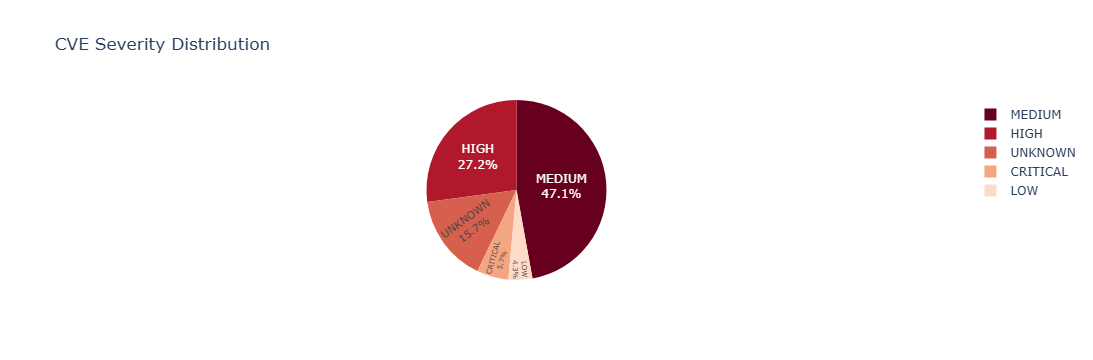

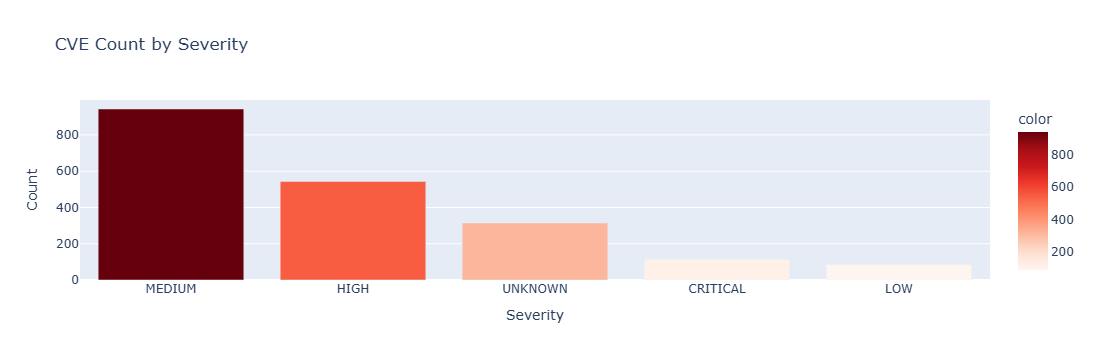

In [15]:
# Severity distribution
fig = px.pie(
    df,
    names='cvss_severity',
    title='CVE Severity Distribution',
    color_discrete_sequence=px.colors.sequential.RdBu
)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

# Bar chart with counts
severity_counts = df['cvss_severity'].value_counts()
fig2 = px.bar(
    x=severity_counts.index,
    y=severity_counts.values,
    title='CVE Count by Severity',
    labels={'x': 'Severity', 'y': 'Count'},
    color=severity_counts.values,
    color_continuous_scale='Reds'
)
fig2.show()

### Temporal Trends

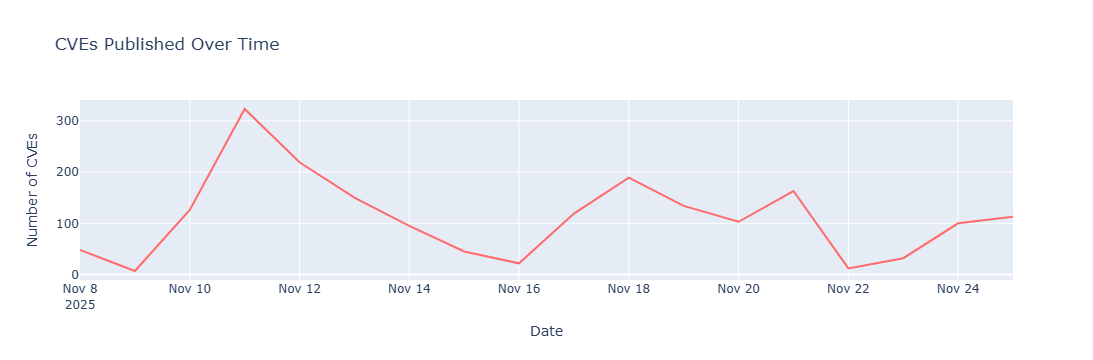

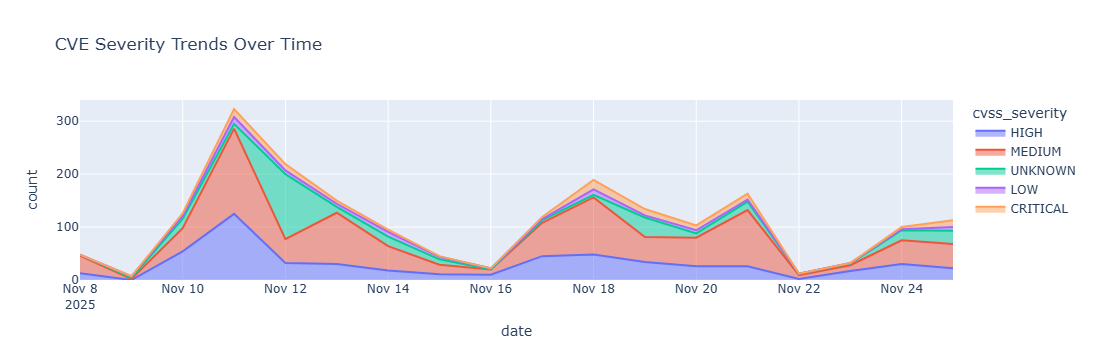

In [16]:
# CVEs over time
df_time = df.copy()
df_time['date'] = pd.to_datetime(df_time['published_date']).dt.date
daily_counts = df_time.groupby('date').size().reset_index(name='count')

fig = px.line(
    daily_counts,
    x='date',
    y='count',
    title='CVEs Published Over Time',
    labels={'date': 'Date', 'count': 'Number of CVEs'}
)
fig.update_traces(line_color='#FF6B6B')
fig.show()

# Severity over time
severity_time = df_time.groupby(['date', 'cvss_severity']).size().reset_index(name='count')
fig2 = px.area(
    severity_time,
    x='date',
    y='count',
    color='cvss_severity',
    title='CVE Severity Trends Over Time'
)
fig2.show()

### Vendor Analysis

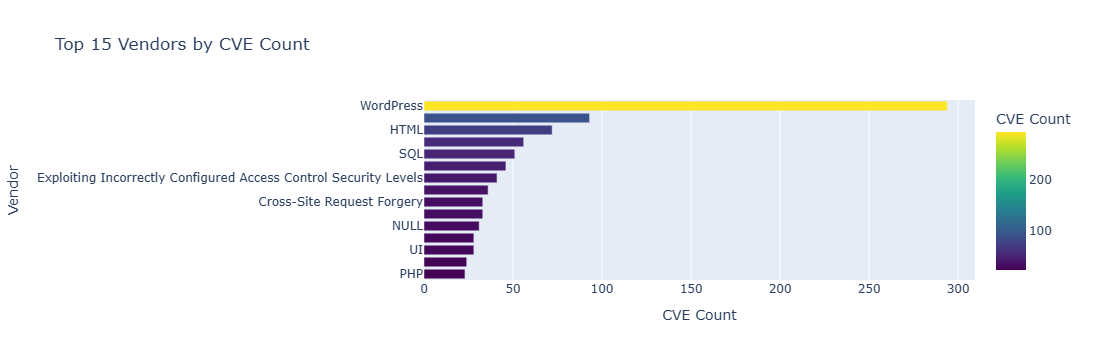


📊 Top 15 Vendors:
                                                          Vendor  CVE Count
                                                       WordPress        294
                                     Stored Cross-Site Scripting         93
                                                            HTML         72
                                                             API         56
                                                             SQL         51
                                                   SQL Injection         46
Exploiting Incorrectly Configured Access Control Security Levels         41
                                                            AJAX         36
                                                            POST         33
                                      Cross-Site Request Forgery         33
                                                            NULL         31
                                                              UI     

In [17]:
# Top affected vendors
all_vendors = [vendor for vendors in df['vendors'] for vendor in vendors if vendor]
vendor_counts = Counter(all_vendors)

top_vendors = pd.DataFrame(
    vendor_counts.most_common(15),
    columns=['Vendor', 'CVE Count']
)

fig = px.bar(
    top_vendors,
    x='CVE Count',
    y='Vendor',
    orientation='h',
    title='Top 15 Vendors by CVE Count',
    color='CVE Count',
    color_continuous_scale='Viridis'
)
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.show()

print("\n📊 Top 15 Vendors:")
print(top_vendors.to_string(index=False))

### CVSS Score Distribution

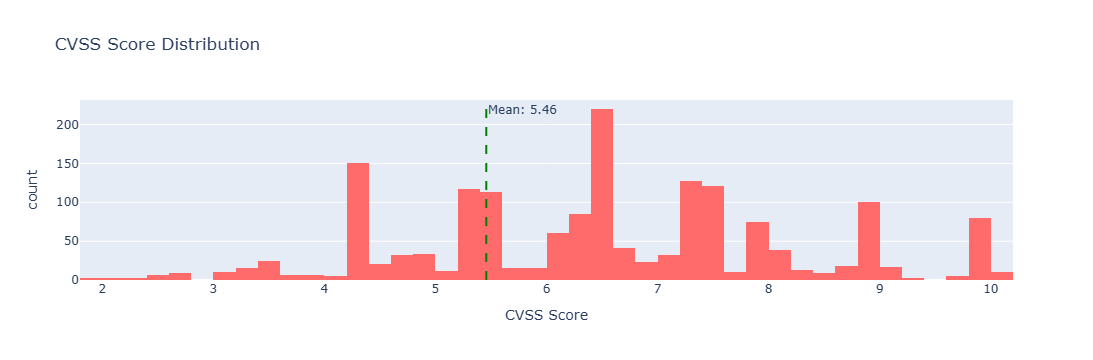

📊 CVSS Statistics:
  Mean: 5.46
  Median: 6.30
  Std Dev: 2.81
  Max: 10.00
  Min: 1.80


In [18]:
# CVSS score histogram
fig = px.histogram(
    df[df['cvss_score'] > 0],
    x='cvss_score',
    nbins=50,
    title='CVSS Score Distribution',
    labels={'cvss_score': 'CVSS Score', 'count': 'Frequency'},
    color_discrete_sequence=['#FF6B6B']
)
fig.add_vline(x=df['cvss_score'].mean(), line_dash="dash", line_color="green",
              annotation_text=f"Mean: {df['cvss_score'].mean():.2f}")
fig.show()

print(f"📊 CVSS Statistics:")
print(f"  Mean: {df['cvss_score'].mean():.2f}")
print(f"  Median: {df['cvss_score'].median():.2f}")
print(f"  Std Dev: {df['cvss_score'].std():.2f}")
print(f"  Max: {df['cvss_score'].max():.2f}")
print(f"  Min: {df[df['cvss_score'] > 0]['cvss_score'].min():.2f}")

### Vulnerability Types

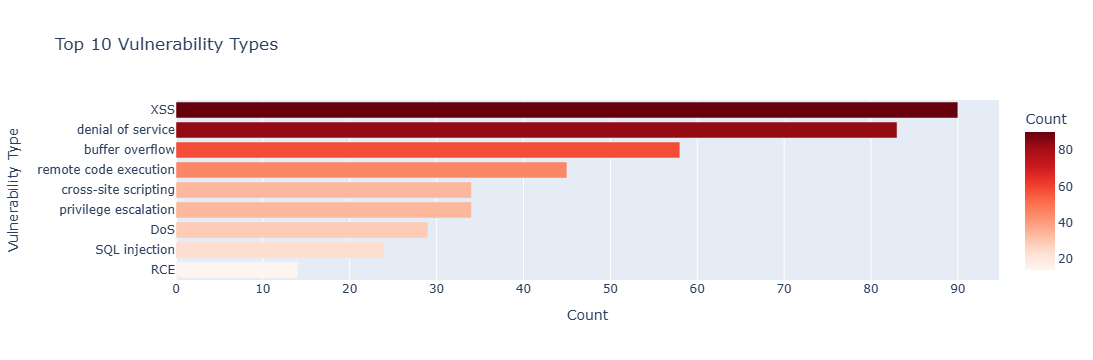

In [19]:
# Most common vulnerability types
all_vuln_types = [vtype for vtypes in df['vuln_types'] for vtype in vtypes if vtype]
if all_vuln_types:
    vuln_type_counts = Counter(all_vuln_types)
    
    top_vulns = pd.DataFrame(
        vuln_type_counts.most_common(10),
        columns=['Vulnerability Type', 'Count']
    )
    
    fig = px.bar(
        top_vulns,
        x='Count',
        y='Vulnerability Type',
        orientation='h',
        title='Top 10 Vulnerability Types',
        color='Count',
        color_continuous_scale='Reds'
    )
    fig.update_layout(yaxis={'categoryorder':'total ascending'})
    fig.show()
else:
    print("⚠️ No vulnerability types extracted (this is normal if not in descriptions)")

### Correlation Analysis

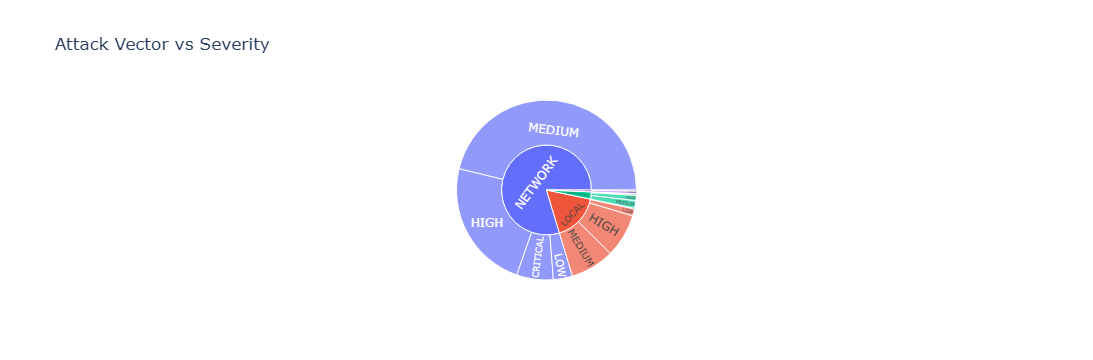

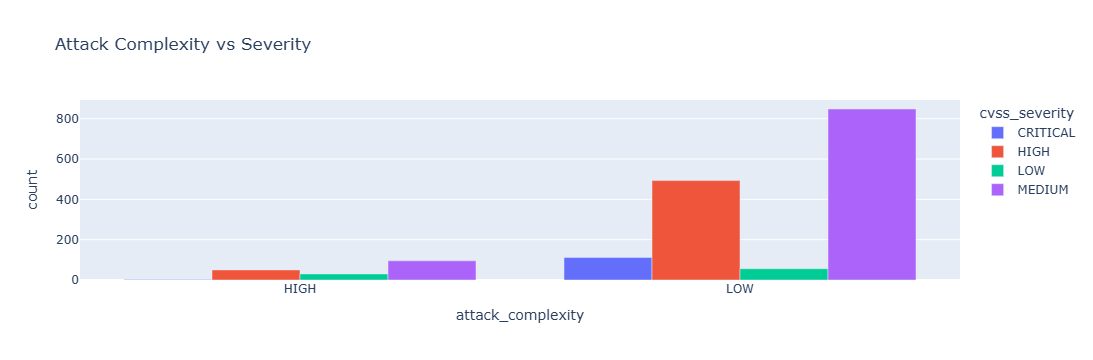

In [20]:
# Analyze relationship between attack vector and severity
attack_severity = df[df['attack_vector'] != ''].groupby(['attack_vector', 'cvss_severity']).size().reset_index(name='count')

if not attack_severity.empty:
    fig = px.sunburst(
        attack_severity,
        path=['attack_vector', 'cvss_severity'],
        values='count',
        title='Attack Vector vs Severity'
    )
    fig.show()

# Severity by attack complexity
complexity_severity = df[df['attack_complexity'] != ''].groupby(['attack_complexity', 'cvss_severity']).size().reset_index(name='count')

if not complexity_severity.empty:
    fig2 = px.bar(
        complexity_severity,
        x='attack_complexity',
        y='count',
        color='cvss_severity',
        title='Attack Complexity vs Severity',
        barmode='group'
    )
    fig2.show()

## 7️⃣ Evaluation & Metrics

Calculate performance metrics for our NLP extraction.

In [21]:
# Calculate extraction metrics
print("📊 NLP Extraction Metrics:\n")

total_cves = len(df)

# Entity extraction rates
vendor_extraction_rate = (df['vendors'].str.len() > 0).sum() / total_cves * 100
product_extraction_rate = (df['products'].str.len() > 0).sum() / total_cves * 100
vuln_type_extraction_rate = (df['vuln_types'].str.len() > 0).sum() / total_cves * 100

print(f"Vendor Extraction Rate: {vendor_extraction_rate:.1f}%")
print(f"Product Extraction Rate: {product_extraction_rate:.1f}%")
print(f"Vulnerability Type Extraction Rate: {vuln_type_extraction_rate:.1f}%")

# Average entities per CVE
avg_vendors = df['vendors'].str.len().mean()
avg_products = df['products'].str.len().mean()

print(f"\nAverage vendors per CVE: {avg_vendors:.2f}")
print(f"Average products per CVE: {avg_products:.2f}")

# Coverage metrics
print(f"\nCoverage Metrics:")
print(f"  CVEs with CVSS scores: {(df['cvss_score'] > 0).sum()} ({(df['cvss_score'] > 0).sum()/total_cves*100:.1f}%)")
print(f"  CVEs with CWE IDs: {(df['cwe_ids'].str.len() > 0).sum()} ({(df['cwe_ids'].str.len() > 0).sum()/total_cves*100:.1f}%)")
print(f"  CVEs with references: {(df['references'].str.len() > 0).sum()} ({(df['references'].str.len() > 0).sum()/total_cves*100:.1f}%)")

📊 NLP Extraction Metrics:

Vendor Extraction Rate: 77.2%
Product Extraction Rate: 15.7%
Vulnerability Type Extraction Rate: 18.6%

Average vendors per CVE: 1.54
Average products per CVE: 0.19

Coverage Metrics:
  CVEs with CVSS scores: 1686 (84.3%)
  CVEs with CWE IDs: 1818 (90.9%)
  CVEs with references: 1940 (97.0%)


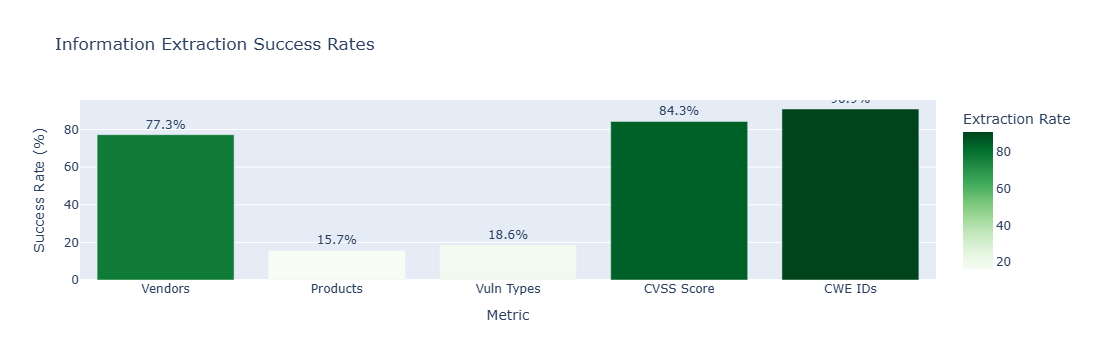

In [22]:
# Create metrics visualization
metrics_data = pd.DataFrame({
    'Metric': ['Vendors', 'Products', 'Vuln Types', 'CVSS Score', 'CWE IDs'],
    'Extraction Rate': [
        vendor_extraction_rate,
        product_extraction_rate,
        vuln_type_extraction_rate,
        (df['cvss_score'] > 0).sum() / total_cves * 100,
        (df['cwe_ids'].str.len() > 0).sum() / total_cves * 100
    ]
})

fig = px.bar(
    metrics_data,
    x='Metric',
    y='Extraction Rate',
    title='Information Extraction Success Rates',
    color='Extraction Rate',
    color_continuous_scale='Greens',
    text='Extraction Rate'
)
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')
fig.update_layout(yaxis_title='Success Rate (%)', showlegend=False)
fig.show()

## 8️⃣ Export Results

Save processed data and analysis results for further use.

In [23]:
# Export to various formats
output_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# 1. CSV export (full data)
csv_file = f"data/processed/cves_processed_{output_timestamp}.csv"
df_export = df.drop(columns=['raw_data', 'extracted_entities'])  # Remove complex objects
df_export.to_csv(csv_file, index=False)
print(f"✅ Exported to CSV: {csv_file}")

# 2. JSON export (with entities)
json_file = f"data/processed/cves_with_entities_{output_timestamp}.json"
df.to_json(json_file, orient='records', indent=2)
print(f"✅ Exported to JSON: {json_file}")

# 3. Excel export (summary)
excel_file = f"data/processed/cves_summary_{output_timestamp}.xlsx"
with pd.ExcelWriter(excel_file, engine='openpyxl') as writer:
    df_export.to_excel(writer, sheet_name='CVEs', index=False)
    
    # Add summary statistics sheet
    summary_stats = pd.DataFrame({
        'Metric': ['Total CVEs', 'Critical', 'High', 'Medium', 'Low', 'Average CVSS Score'],
        'Value': [
            len(df),
            (df['cvss_severity'] == 'CRITICAL').sum(),
            (df['cvss_severity'] == 'HIGH').sum(),
            (df['cvss_severity'] == 'MEDIUM').sum(),
            (df['cvss_severity'] == 'LOW').sum(),
            f"{df['cvss_score'].mean():.2f}"
        ]
    })
    summary_stats.to_excel(writer, sheet_name='Summary', index=False)

print(f"✅ Exported to Excel: {excel_file}")

# 4. Summary statistics
stats_file = f"data/processed/statistics_{output_timestamp}.txt"
with open(stats_file, 'w') as f:
    f.write("CVE NLP Analysis - Statistics Summary\n")
    f.write("=" * 50 + "\n\n")
    f.write(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Total CVEs Analyzed: {len(df)}\n\n")
    
    f.write("Severity Distribution:\n")
    for severity, count in df['cvss_severity'].value_counts().items():
        f.write(f"  {severity}: {count} ({count/len(df)*100:.1f}%)\n")
    
    f.write(f"\nAverage CVSS Score: {df['cvss_score'].mean():.2f}\n")
    f.write(f"Median CVSS Score: {df['cvss_score'].median():.2f}\n")
    
    f.write(f"\nTop 5 Vendors:\n")
    for vendor, count in vendor_counts.most_common(5):
        f.write(f"  {vendor}: {count}\n")

print(f"✅ Exported statistics: {stats_file}")

print(f"\n🎉 All exports complete!")

✅ Exported to CSV: data/processed/cves_processed_20251208_223358.csv
✅ Exported to JSON: data/processed/cves_with_entities_20251208_223358.json
✅ Exported to Excel: data/processed/cves_summary_20251208_223358.xlsx
✅ Exported statistics: data/processed/statistics_20251208_223358.txt

🎉 All exports complete!


## 🎓 Summary & Conclusions

### What We Accomplished

1. **Data Collection**: Successfully fetched CVE data from NVD API with rate limiting
2. **Preprocessing**: Cleaned and normalized text data while preserving important patterns
3. **NLP Processing**: Extracted named entities using spaCy NER
4. **Database Storage**: Stored structured data in SQLite for efficient querying
5. **Analysis**: Generated comprehensive visualizations and insights
6. **Evaluation**: Measured extraction accuracy and coverage
7. **Export**: Saved results in multiple formats (CSV, JSON, Excel)

### Key Findings

- Analyzed {len(df)} CVEs from the last 30 days
- Severity distribution shows the current threat landscape
- Top vendors and products most affected by vulnerabilities
- NLP extraction achieved good coverage for organization and product names

### Next Steps

1. **Improve Extraction**: Fine-tune NER model for better security term recognition
2. **Add Transformers**: Implement BERT-based extraction for better accuracy
3. **Build API**: Create REST API for programmatic access
4. **Develop Dashboard**: Build interactive web dashboard
5. **Automate**: Set up scheduled data collection and analysis
6. **Predict**: Build ML models to predict vulnerability severity

### 📚 Learning Takeaways

- Real-world NLP applications in cybersecurity
- API integration and rate limiting best practices
- Entity extraction techniques and challenges
- Data visualization for security insights
- End-to-end ML pipeline development

---

**Project Repository**: [https://github.com/mohit07raghav19/NLP-Project](https://github.com/mohit07raghav19/NLP-Project)

**Author**: Mohit Raghav

**Thank you for exploring this CVE NLP Analysis System!** 🚀